# Vision Transformer (ViT) Image Predictor

This notebook loads a pre-trained Vision Transformer model and makes predictions on images.

## Features:
- ✅ Load saved ViT model
- ✅ Predict single images from file path
- ✅ Batch prediction with visualization
- ✅ Confidence scores and detailed results
- ✅ Support for custom image paths

## 1. Setup and Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
import matplotlib.pyplot as plt
from PIL import Image
import os
import json
from tqdm import tqdm

# Check GPU availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

/home/ubuntu/anaconda3/envs/rapids-env/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/ubuntu/anaconda3/envs/rapids-env/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/ubuntu/anaconda3/envs/rapids-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.5.1
CUDA available: True
GPU: NVIDIA GeForce RTX 3060 Ti

Using device: cuda


## 2. Configuration and Paths

In [2]:
# Paths
#BASE_PATH = '/media/ubuntu/NVME/AIML project/AlphaNum2'
#TEST_PATH = os.path.join(BASE_PATH, 'test')
RESULTS_PATH = "/home/ubuntu/Desktop/AIML project/results/ViT"

# Model files
MODEL_PATH = os.path.join(RESULTS_PATH, 'vit_model.pth')
CLASSES_PATH = os.path.join(RESULTS_PATH, 'classes.txt')

# Image size (must match training)
IMG_SIZE = 48

print(f"Model Path: {MODEL_PATH}")
print(f"Classes Path: {CLASSES_PATH}")
#print(f"Test Path: {TEST_PATH}")
print(f"Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"\nModel file exists: {os.path.exists(MODEL_PATH)}")
print(f"Classes file exists: {os.path.exists(CLASSES_PATH)}")

Model Path: /home/ubuntu/Desktop/AIML project/results/ViT/vit_model.pth
Classes Path: /home/ubuntu/Desktop/AIML project/results/ViT/classes.txt
Image Size: 48x48

Model file exists: True
Classes file exists: True


## 3. Define Image Transforms

In [3]:
# Image transforms (must match training)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

print("Image transform pipeline:")
print("  1. Convert to grayscale")
print(f"  2. Resize to {IMG_SIZE}x{IMG_SIZE}")
print("  3. Convert to tensor")
print("  4. Normalize (mean=0.5, std=0.5)")

Image transform pipeline:
  1. Convert to grayscale
  2. Resize to 48x48
  3. Convert to tensor
  4. Normalize (mean=0.5, std=0.5)


## 4. Load Class Names

In [4]:
# Load class names
with open(CLASSES_PATH, 'r') as f:
    class_names = f.read().strip().split('\n')

num_classes = len(class_names)

print(f"Number of classes: {num_classes}")
print(f"\nFirst 10 classes: {class_names[:10]}")
print(f"Last 10 classes: {class_names[-10:]}")

# Show character representation
print("\nSample class mappings:")
for i in [0, 10, 25, 35, 50, -1]:
    cls = class_names[i]
    char = chr(int(cls)) if cls != '999' else 'NULL/Invalid'
    print(f"  Class {cls} → '{char}'")

Number of classes: 53

First 10 classes: ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109']
Last 10 classes: ['85', '86', '87', '88', '89', '90', '97', '98', '99', '999']

Sample class mappings:
  Class 100 → 'd'
  Class 110 → 'n'
  Class 67 → 'C'
  Class 77 → 'M'
  Class 98 → 'b'
  Class 999 → 'NULL/Invalid'


## 5. Define and Load Model

In [5]:
# Create Vision Transformer model architecture
def create_vit_model(num_classes, img_size=48):
    model = timm.create_model(
        'vit_tiny_patch16_224',
        pretrained=False,
        num_classes=num_classes,
        img_size=img_size,
        in_chans=1
    )
    return model

# Create model
print("Creating ViT model architecture...")
model = create_vit_model(num_classes, img_size=IMG_SIZE)

# Load trained weights
print(f"Loading model weights from: {MODEL_PATH}")
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)
model.eval()

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\n Model loaded successfully!")
print(f"   Architecture: ViT-Tiny")
print(f"   Parameters: {total_params:,}")
print(f"   Device: {device}")
print(f"   Classes: {num_classes}")

Creating ViT model architecture...
Loading model weights from: /home/ubuntu/Desktop/AIML project/results/ViT/vit_model.pth


/tmp/ipykernel_4847/1660097977.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=device))



 Model loaded successfully!
   Architecture: ViT-Tiny
   Parameters: 5,400,437
   Device: cuda
   Classes: 53


## 6. Single Image Prediction Function

In [6]:
def predict_single_image(model, image_path, transform, class_names, device, show_viz=True):
    """
    Predict a single image from file path.
    
    Args:
        model: Trained model
        image_path: Path to image file
        transform: Image transformation pipeline
        class_names: List of class names
        device: Computation device (cuda/cpu)
        show_viz: Show visualization
    
    Returns:
        predicted_class, confidence, predicted_character
    """
    # Check if file exists
    if not os.path.exists(image_path):
        print(f" Error: File not found at '{image_path}'")
        print("Please check the path and try again.")
        return None, None, None
    
    try:
        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        original_image = image.copy()
        
        # Apply transforms
        input_tensor = transform(image).unsqueeze(0).to(device)
        
        # Make prediction
        model.eval()
        with torch.no_grad():
            output = model(input_tensor)
            probs = F.softmax(output, dim=1)
            confidence, predicted_idx = torch.max(probs, 1)
        
        # Get results
        pred_class = class_names[predicted_idx.item()]
        conf_percent = confidence.item() * 100
        pred_char = chr(int(pred_class)) if pred_class != '999' else 'NULL/Invalid'
        
        if show_viz:
            # Visualize
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))
            
            # Original image
            axes[0].imshow(original_image, cmap='gray')
            axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
            axes[0].axis('off')
            
            # Processed image
            processed_img = input_tensor.cpu().squeeze().numpy()
            axes[1].imshow(processed_img, cmap='gray')
            axes[1].set_title(f'Processed ({IMG_SIZE}x{IMG_SIZE})', fontsize=14, fontweight='bold')
            axes[1].axis('off')
            
            # Add prediction text with large, clear formatting
            confidence_color = 'green' if conf_percent > 80 else 'orange' if conf_percent > 60 else 'red'
            fig.suptitle(f'Predicted: "{pred_char}" | Confidence: {conf_percent:.2f}%', 
                         fontsize=18, fontweight='bold', color=confidence_color)
            plt.tight_layout()
            plt.show()
        
        # Print detailed results
        print("\n" + "="*70)
        print("                      PREDICTION RESULTS")
        print("="*70)
        print(f" Image Path:           {image_path}")
        print(f" Predicted Character:  '{pred_char}'")
        print(f"  ASCII Code:            {pred_class}")
        print(f" Confidence:           {conf_percent:.2f}%")
        confidence_bar = "█" * int(conf_percent // 5) + "░" * (20 - int(conf_percent // 5))
        print(f" Confidence Bar:       [{confidence_bar}]")
        print(f" Confidence Level:     {'✅ High' if conf_percent > 90 else '⚠️ Medium' if conf_percent > 70 else '❌ Low'}")
        print("="*70 + "\n")
        
        return pred_class, conf_percent, pred_char
        
    except Exception as e:
        print(f" Error: {e}")
        print("Make sure the file is a valid image format (PNG, JPG, JPEG, etc.)")
        return None, None, None

print(" Prediction function defined!")

 Prediction function defined!


## 7. Predict Custom Image

**Change the `IMAGE_PATH` variable below to predict your own image!**

🔍 Loading image from: /home/ubuntu/Pictures/asaad.png



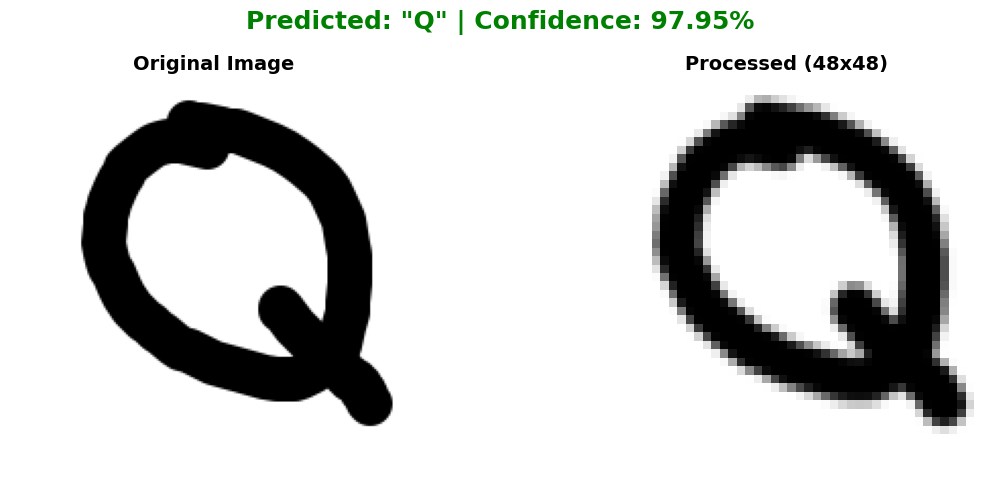


                      PREDICTION RESULTS
 Image Path:           /home/ubuntu/Pictures/asaad.png
 Predicted Character:  'Q'
  ASCII Code:            81
 Confidence:           97.95%
 Confidence Bar:       [███████████████████░]
 Confidence Level:     ✅ High

✅ Prediction complete! The model predicts: 'Q' with 98.0% confidence


In [7]:
# ============================================================================
#  CUSTOM IMAGE PATH - CHANGE THIS TO YOUR IMAGE FILE
# ============================================================================
# Examples:
#   - Linux:   '/home/username/Pictures/my_image.png'
#   - Windows: 'C:/Users/username/Pictures/my_image.png'
#   - Test:    '/media/ubuntu/NVME/AIML project/AlphaNum2/test/65/image_001.jpg'

IMAGE_PATH = '/home/ubuntu/Pictures/asaad.png'  #  CHANGE THIS PATH

# ============================================================================

print(f"🔍 Loading image from: {IMAGE_PATH}\n")
predicted_class, confidence, predicted_char = predict_single_image(
    model=model,
    image_path=IMAGE_PATH,
    transform=transform,
    class_names=class_names,
    device=device,
    show_viz=True
)

if predicted_char:
    print(f"✅ Prediction complete! The model predicts: '{predicted_char}' with {confidence:.1f}% confidence")